# Summary

This notebook compares the performance of several base learners.

It uses the Sine low speed high severity dataset.

It can show individual executions plots, but can also be used to get an average.

# Libraries

In [155]:
import sys

sys.path.append("../")

from src.convex_combination import ConvexCombination
from src.ddd import DDD
from src.online_bagging import OnlineBagging
from src.drift_detector import DriftDetectorWrapper

# Preparation

## Dataset

In [156]:
# Sine low speed high severity
from river.datasets import synth
from itertools import chain

class_list = [0, 1]
n_samples = 10000

stream1 = synth.Sine(classification_function=2, balance_classes=True, has_noise=True)
stream2 = synth.Sine(classification_function=3, balance_classes=True, has_noise=True)
drift_stream = synth.ConceptDriftStream(stream1, stream2, position=4000, width=1500)

dataset = drift_stream.take(n_samples)

## Models

In [157]:
from river import tree, ensemble, drift
from river import preprocessing, optim, linear_model, neighbors, naive_bayes
from river import compat
from sklearn.neural_network import MLPClassifier

model1 = tree.HoeffdingTreeClassifier(delta=1e-07, max_depth=25)

model2 = naive_bayes.GaussianNB()

model3 = preprocessing.StandardScaler() | linear_model.LogisticRegression(optimizer=optim.SGD(0.1))

model4 = preprocessing.StandardScaler() | linear_model.Perceptron()

model5 = compat.convert_sklearn_to_river(MLPClassifier((25, 5)), classes=class_list)

p_ht = {"delta": 1e-07, "max_depth": 25}
p_drift_detector = {"alpha": 0.90, "beta": 0.85}
p_slow_ensemble = {
    "base_classifier_class": tree.HoeffdingTreeClassifier,
    "n_classifiers": 10,
    "lambda_diversity": 1,
    "p_classifiers": p_ht,
    "class_list": class_list,
}
slow_learner = DriftDetectorWrapper(
    OnlineBagging(**p_slow_ensemble),
    drift.binary.EDDM(**p_drift_detector),
    train_in_background=False,
)

modeladaptive = tree.HoeffdingAdaptiveTreeClassifier(delta=1e-07, max_depth=25)
modelknn = neighbors.KNNClassifier(weighted=False)

model_list = [model1, model2, model3, model4, model5]
model_names = ["Hoeffding Tree", "Naive Bayes", "Logistic Regr.", "Perceptron", "MLP"]
n_models = len(model_list)

# Execution

## Main loop

In [158]:
# Lists for storing predictions convex
y_true_list = []
y_pred_list = []

for i in range(n_models):
    y_pred_list.append([])

In [159]:
# Generic loop for convex storing predictions
for idx, (x, y) in enumerate(dataset):
    y_true_list.append(y)
    for i in range(n_models):
        # Predict and update the model
        y_pred = model_list[i].predict_one(x)
        model_list[i].learn_one(x, y)
        y_pred_list[i].append(y_pred)

## Metrics

In [160]:
# Metrics
from river import metrics, utils


metrics_list = []
metrics_cum_list = []

for i in range(n_models):
    model_metrics = [utils.Rolling(metrics.Accuracy(), 250), utils.Rolling(metrics.Accuracy(), 1000)]
    n_metrics = len(model_metrics)

    metrics_list.append(model_metrics)
    metrics_cum_list.append([[] for _ in range(n_metrics)])

In [161]:
# Convert predictions to metrics
for i in range(n_models):
    for idx in range(len(y_true_list)):
        y = y_true_list[idx]
        y_pred = y_pred_list[i][idx]
        # Update the metrics
        for j in range(n_metrics):
            try:
                metrics_list[i][j].update(y, y_pred)
            except:
                metrics_list[i][j].update(y, class_list[0])
                print("ERROR")
            metrics_cum_list[i][j].append(metrics_list[i][j].get())

In [162]:
# Create metrics average
from river import stats

# Toggle this flag to reset global metrics
# If true it resets global metrics
# If false it does nothing and increases the n_executions counter to keep track
reset_global_metrics = False

if reset_global_metrics:
    n_executions = 0
    metrics_avg_list = []
    metrics_final_list = []
    for i in range(n_models):
        metrics_avg_list.append([])
        metrics_final_list.append([])
        for idx in range(1, n_samples + 1):
            metrics_avg_list[i].append(stats.Mean())
            metrics_final_list[i].append(0)

n_executions += 1
print(n_executions)

10


In [163]:
# Update metrics average
metric_n = 1

for i in range(n_models):
    other_idx = 0
    for idx in range(n_samples):
        metrics_avg_list[i][other_idx].update(metrics_cum_list[i][metric_n][idx])
        metrics_final_list[i][other_idx] = metrics_avg_list[i][other_idx].get()
        other_idx += 1

# Plotting

In [ ]:
# Average plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
for i in range(n_models):
    ax.plot(range(1, n_samples + 1), metrics_final_list[i], "-", label=model_names[i])
ax.set_xlim(0, n_samples)
ax.set_ylim(0, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

In [ ]:
# Current plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
for i in range(n_models):
    ax.plot(range(1, n_samples + 1), metrics_cum_list[i][metric_n], "-", label=model_names[i])
ax.set_xlim(0, n_samples)
ax.set_ylim(0, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

## Past plots

Executed 2023-09-01 12:24:33.616409


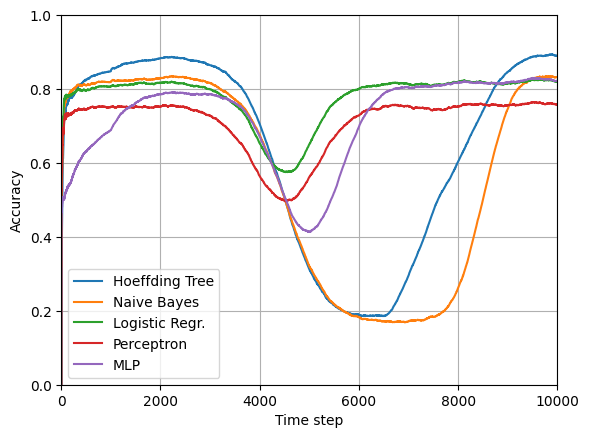

In [165]:
# Final average plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
for i in range(n_models):
    ax.plot(range(1, n_samples + 1), metrics_final_list[i], "-", label=model_names[i])
ax.set_xlim(0, n_samples)
ax.set_ylim(0, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

Executed 2023-09-01 12:38:29.597074


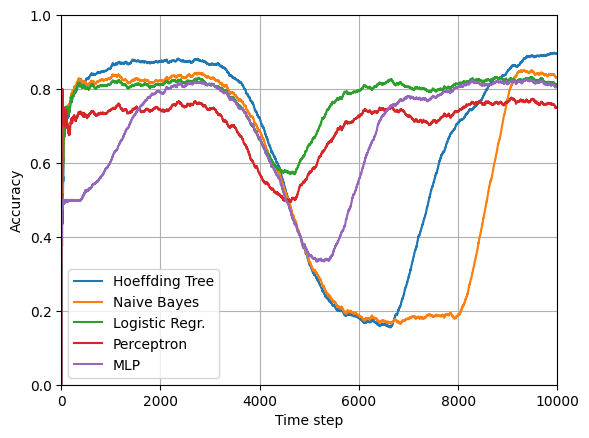

In [166]:
# Last current plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
for i in range(n_models):
    ax.plot(range(1, n_samples + 1), metrics_cum_list[i][metric_n], "-", label=model_names[i])
ax.set_xlim(0, n_samples)
ax.set_ylim(0, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

Executed 2023-08-31 15:55:32.205717


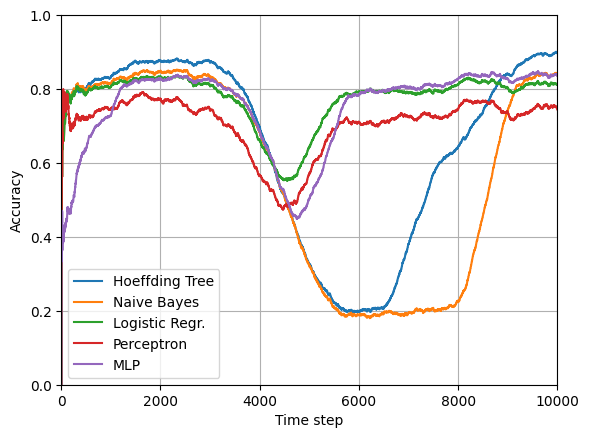

In [51]:
# Nice exeuction
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
for i in range(n_models):
    ax.plot(range(1, n_samples + 1), metrics_cum_list[i][metric_n], "-", label=model_names[i])
ax.set_xlim(0, n_samples)
ax.set_ylim(0, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")